# Visualizing A* on the semester graph
This notebook shows how to build a simple semester graph, run A* to find a path from your next semester to semester 8, and visualize the result.

In [6]:
import json
import heapq
from typing import Any, Dict, List, Optional, Tuple

# ===== Load JSON helpers =====
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_knowledge():
    courses = load_json("data/cs_courses.json") or load_json("data/courses.json")
    prereqs = load_json("data/prerequisite_rules.json") or load_json("data/prerequisites.json")
    career_keywords = load_json("data/career_keywords.json")
    lab_preferences = load_json("data/lab_preferences.json")
    return courses, prereqs, career_keywords, lab_preferences

# ===== Helper functions =====
def is_elective(course):
    return "wajib" not in (course.get("type") or "").lower()

def offered_in_semester(course, sem):
    sems = course.get("semesters") or []
    if not sems:
        return True
    return sem in [int(s) for s in sems if isinstance(s, (int, str)) and str(s).isdigit()]

def prereq_ok(code, taken, rules):
    entry = rules.get(code)
    if not entry:
        return True
    prereqs = [p.get("code") for p in entry.get("prerequisites", []) if not p.get("is_corequisite")]
    return set(prereqs).issubset(taken)

def matches_interest(course, interests):
    text = " ".join([
        course.get("course_name_en", ""),
        course.get("course_name_id", ""),
        " ".join(course.get("topics", []) or []),
    ]).lower()
    return sum(1 for i in interests if i.lower() in text)

def is_relevant_to_career(course, target, career_keywords):
    target = (target or "").lower()
    haystack = " ".join([
        course.get("course_name_en", ""),
        course.get("course_name_id", ""),
        " ".join(course.get("topics", []) or []),
        course.get("type", "") or "",
    ]).lower()
    for career, keywords in (career_keywords or {}).items():
        ck = (career or "").lower()
        if ck in target or target in ck:
            if any((kw or "").lower() in haystack for kw in (keywords or [])):
                return True
    for token in target.split():
        if token and token in haystack:
            return True
    return False

def lab_category(course_type):
    t = (course_type or "").lower()
    if "algoritma" in t or "komputasi" in t:
        return "algkom"
    if "rekayasa perangkat lunak" in t or "rpl" in t or "data" in t:
        return "rpld"
    if "sistem cerdas" in t or "intelligent" in t:
        return "ai"
    if "jaringan" in t or "network" in t:
        return "skj"
    return None

def lab_preferences_for_career(career_goal, lab_preferences):
    ck = (career_goal or "").lower()
    for k, v in (lab_preferences or {}).items():
        lk = (k or "").lower()
        if lk in ck or ck in lk:
            return v or []
    return []

def score_course(course, interests, career_goal, career_keywords, lab_preferences):
    score = 0
    score += 15 * matches_interest(course, interests or [])
    if career_goal and is_relevant_to_career(course, career_goal, career_keywords):
        score += 10
    lab_cat = lab_category(course.get("type"))
    lab_pref = lab_preferences_for_career(career_goal, lab_preferences)
    if lab_cat and lab_pref and lab_cat in lab_pref:
        idx = lab_pref.index(lab_cat)
        weights = [20, 12, 6, 3]
        score += weights[idx] if idx < len(weights) else 2
    return score

def prereq_depth(prereq_rules, code, depth=0):
    entry = prereq_rules.get(code)
    if not entry:
        return depth
    prereqs = [p.get("code") for p in entry.get("prerequisites", []) if p.get("code")]
    if not prereqs:
        return depth
    return max(prereq_depth(prereq_rules, p, depth + 1) for p in prereqs)

# ===== Graph builder =====
def build_course_graph(courses, prereq_rules, interests, career_goal, career_keywords, lab_preferences):
    graph = {}
    course_map = {c.get("course_code"): c for c in courses if c.get("course_code")}
    for code, course in course_map.items():
        graph.setdefault(code, [])
        entry = prereq_rules.get(code, {})
        prereqs = [p.get("code") for p in entry.get("prerequisites", []) if p.get("code")]
        for pre in prereqs:
            if pre not in course_map:
                continue
            sc = score_course(course, interests, career_goal, career_keywords, lab_preferences)
            depth = prereq_depth(prereq_rules, code)
            cost = (1.0 + 0.2 * depth) / (sc + 1e-5)
            graph.setdefault(pre, []).append((code, cost))
    return graph

def heuristic(a, b, prereq_rules):
    return abs(prereq_depth(prereq_rules, a) - prereq_depth(prereq_rules, b))

# ===== A* with process logging =====
def astar_debug(graph, start, goal, prereq_rules):
    open_set = [(0, start)]
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal, prereq_rules)}

    print(f"\n🔹 Running A* from {start} → {goal}")
    print(f"{'Node':<10}{'g(n)':<10}{'h(n)':<10}{'f(n)':<10}")

    while open_set:
        _, current = heapq.heappop(open_set)
        print(f"→ Expanding node: {current}")
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return list(reversed(path)), f_score

        for neighbor, cost in graph.get(current, []):
            tentative_g = g_score[current] + cost
            h = heuristic(neighbor, goal, prereq_rules)
            f = tentative_g + h
            print(f"   {neighbor:<10}{tentative_g:<10.4f}{h:<10.4f}{f:<10.4f}")
            if tentative_g < g_score.get(neighbor, float("inf")):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = f
                heapq.heappush(open_set, (f, neighbor))
    return None, f_score

# ===== Main planner =====
def plan_until_graduation_astar_debug(
    name: str,
    courses_taken: List[str],
    interests: List[str],
    career_goal: str,
    current_semester: int,
    per_semester_sks_cap: Optional[int] = None,
    per_semester_count_cap: Optional[int] = 5,
    log_path: str = "astar_log.txt"
):
    """
    Same as plan_until_graduation_astar, but prints and saves debug logs
    (A* node expansions, f(n), etc.) to both console and file.
    """
    courses, prereq, career_keywords, lab_preferences = load_knowledge()
    graph = build_course_graph(courses, prereq, interests, career_goal, career_keywords, lab_preferences)
    course_map = {c.get("course_code"): c for c in courses if c.get("course_code")}
    available_nodes = [c.get("course_code") for c in courses if c.get("course_code")]
    taken = set(courses_taken)
    schedule = []

    log = []  # collect output lines

    def logprint(*args, **kwargs):
        text = " ".join(str(a) for a in args)
        print(text, **kwargs)
        log.append(text)

    for sem in range(current_semester + 1, 8):
        logprint(f"\n=== 📘 Semester {sem} ===\n")
        chosen = []
        total_sks = 0

        candidates = [
            c for c in available_nodes
            if prereq_ok(c, taken, prereq)
            and c not in taken
            and is_elective(course_map.get(c, {}))
            and offered_in_semester(course_map.get(c, {}), sem)
        ]

        best_item = None

        for code in candidates:
            course = course_map.get(code)
            if not course:
                continue

            entry = prereq.get(code, {})
            pre_list = [p.get("code") for p in entry.get("prerequisites", []) if p.get("code")]
            start_nodes = pre_list if pre_list else [code]

            sc = score_course(course, interests, career_goal, career_keywords, lab_preferences)
            depth = prereq_depth(prereq, code)
            own_cost = (1.0 + 0.2 * depth) / (sc + 1e-5)

            best_path_cost = float("inf")
            for s in start_nodes:
                logprint(f"🔹 Running A* from {s} → {code}")
                open_set = [(0, s)]
                came_from = {}
                g_score = {s: 0}
                f_score = {s: heuristic(s, code, prereq)}

                logprint("Node      g(n)      h(n)      f(n)      ")

                while open_set:
                    _, current = heapq.heappop(open_set)
                    logprint(f"→ Expanding node: {current}")

                    if current == code:
                        logprint(f"✅ {code} | Score={sc:.2f}, Depth={depth}, Cost={own_cost:.4f}\n")
                        break

                    for neighbor, cost in graph.get(current, []):
                        tentative_g = g_score[current] + cost
                        if tentative_g < g_score.get(neighbor, float('inf')):
                            came_from[neighbor] = current
                            g_score[neighbor] = tentative_g
                            f = tentative_g + heuristic(neighbor, code, prereq)
                            f_score[neighbor] = f
                            heapq.heappush(open_set, (f, neighbor))
                            logprint(f"   {neighbor:<12}{tentative_g:<10.4f}{heuristic(neighbor, code, prereq):<10.4f}{f:<10.4f}")

                path = astar(graph, s, code, prereq)
                if path:
                    if len(path) <= 1:
                        cst = own_cost
                    else:
                        cst = path_cost(graph, path)
                    if cst < best_path_cost:
                        best_path_cost = cst

            if best_path_cost == float("inf"):
                best_path_cost = own_cost

            item = (best_path_cost, -sc, code, course)
            if best_item is None or item < best_item:
                best_item = item

        if best_item:
            _, _, _, best_course = best_item
            sks = int(best_course.get("sks") or 0)
            if (per_semester_sks_cap is None) or (sks <= per_semester_sks_cap):
                chosen = [best_course]
                total_sks = sks
                taken.add(best_course.get("course_code"))
                logprint(f"📍 Selected course for semester {sem}: {best_course.get('course_code')} - {best_course.get('course_name_en')}")

        schedule.append({
            "semester": sem,
            "sks": total_sks,
            "courses": [
                {
                    "course_code": c.get("course_code"),
                    "course_name_en": c.get("course_name_en") or c.get("course_name_id"),
                    "sks": c.get("sks")
                }
                for c in chosen
            ]
        })

    # Save all logs to file
    with open(log_path, "w", encoding="utf-8") as f:
        f.write("\n".join(log))
    print(f"\n📝 Full A* process saved to {log_path}")

    return {
        "name": name,
        "start_semester": current_semester,
        "schedule": schedule
    }


In [11]:
import heapq

def heuristic(a, b, prereq_rules):
    """Estimate distance between two courses based on prerequisite depth."""
    def prereq_depth(prereq_rules, code, depth=0):
        entry = prereq_rules.get(code)
        if not entry:
            return depth
        prereqs = [p.get("code") for p in entry.get("prerequisites", []) if p.get("code")]
        if not prereqs:
            return depth
        return max(prereq_depth(prereq_rules, p, depth + 1) for p in prereqs)
    return abs(prereq_depth(prereq_rules, a) - prereq_depth(prereq_rules, b))

def astar(graph, start, goal, prereq_rules):
    """Perform A* search on the course graph to find the optimal prerequisite path."""
    open_set = [(0, start)]
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal, prereq_rules)}

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return list(reversed(path))

        for neighbor, cost in graph.get(current, []):
            tentative_g = g_score[current] + cost
            if tentative_g < g_score.get(neighbor, float('inf')):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f = tentative_g + heuristic(neighbor, goal, prereq_rules)
                f_score[neighbor] = f
                heapq.heappush(open_set, (f, neighbor))
    return None

def path_cost(graph, path):
    """Compute total cost of a path based on edge weights."""
    total = 0.0
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        for nb, cost in graph.get(u, []):
            if nb == v:
                total += cost
                break
    return total


In [12]:
if __name__ == "__main__":
    name = "Deira"
    courses_taken = ["MII21-1201", "MII21-1203", "MII21-2401", "MII21-1002"]
    current_semester = 3
    interests = ["machine learning", "AI"]
    career_goal = "data scientist"

    plan_until_graduation_astar_debug(
        name=name,
        courses_taken=courses_taken,
        interests=interests,
        career_goal=career_goal,
        current_semester=current_semester
    )



=== 📘 Semester 4 ===

🔹 Running A* from MII21-2205 → MII21-2205
Node      g(n)      h(n)      f(n)      
→ Expanding node: MII21-2205
✅ MII21-2205 | Score=12.00, Depth=0, Cost=0.0833

🔹 Running A* from MII21-1002 → MII21-2404
Node      g(n)      h(n)      f(n)      
→ Expanding node: MII21-1002
   MII21-2401  120000.00000.0000    120000.0000
   MII21-2202  120000.00000.0000    120000.0000
   MII21-2404  0.0400    0.0000    0.0400    
→ Expanding node: MII21-2404
✅ MII21-2404 | Score=30.00, Depth=1, Cost=0.0400

🔹 Running A* from MII21-2401 → MII21-2405
Node      g(n)      h(n)      f(n)      
→ Expanding node: MII21-2401
   MII21-2402  0.0560    1.0000    1.0560    
   MII21-2410  0.0467    1.0000    1.0467    
   MII21-2405  0.0533    0.0000    0.0533    
   MII21-3403  0.0467    1.0000    1.0467    
   MII21-3405  0.0467    1.0000    1.0467    
   MII21-3407  0.0467    1.0000    1.0467    
→ Expanding node: MII21-2405
✅ MII21-2405 | Score=30.00, Depth=3, Cost=0.0533

🔹 Running A* fr

✅ Parsed 7 A* runs for Semester 4.


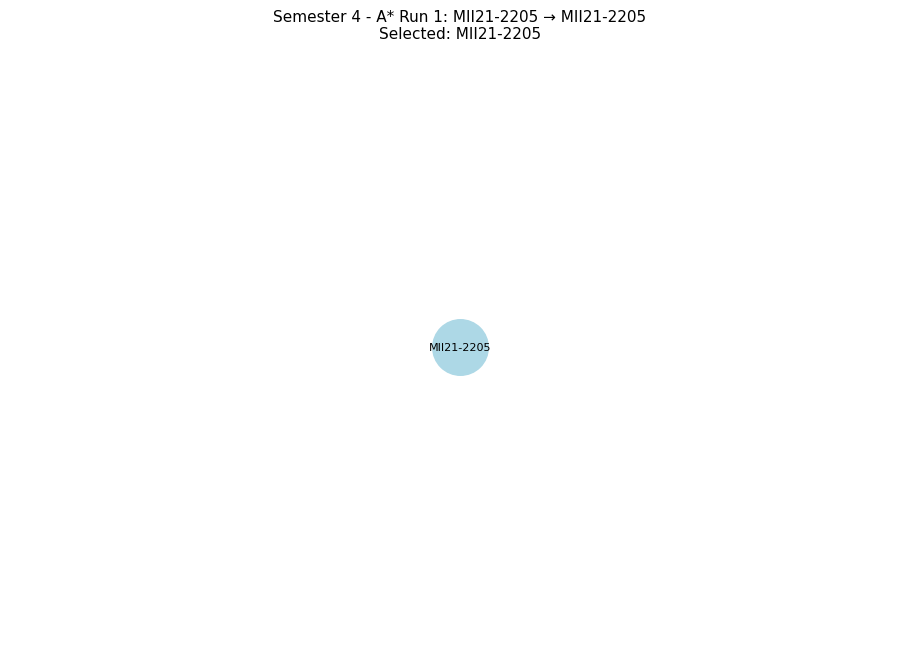

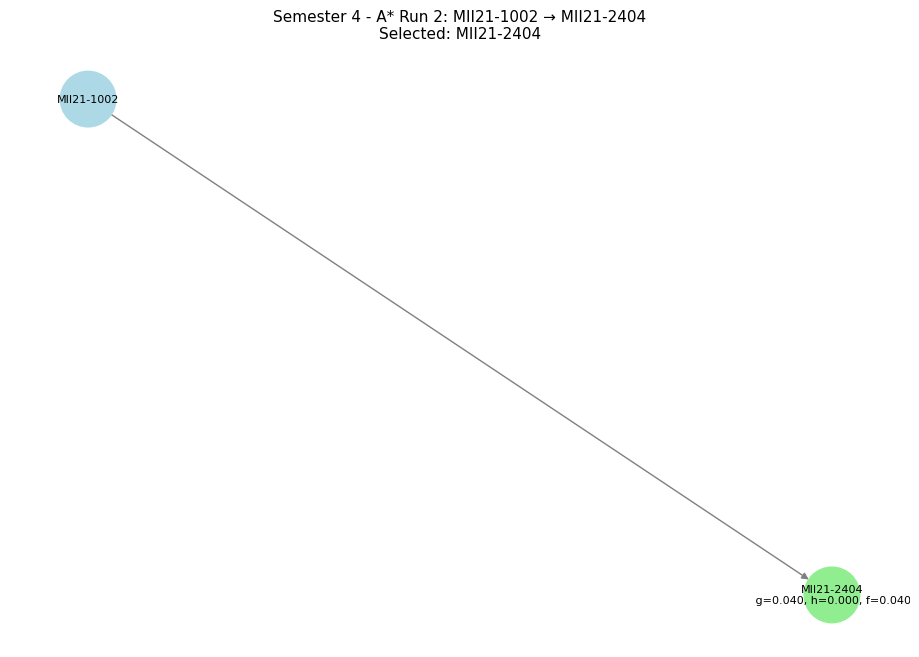

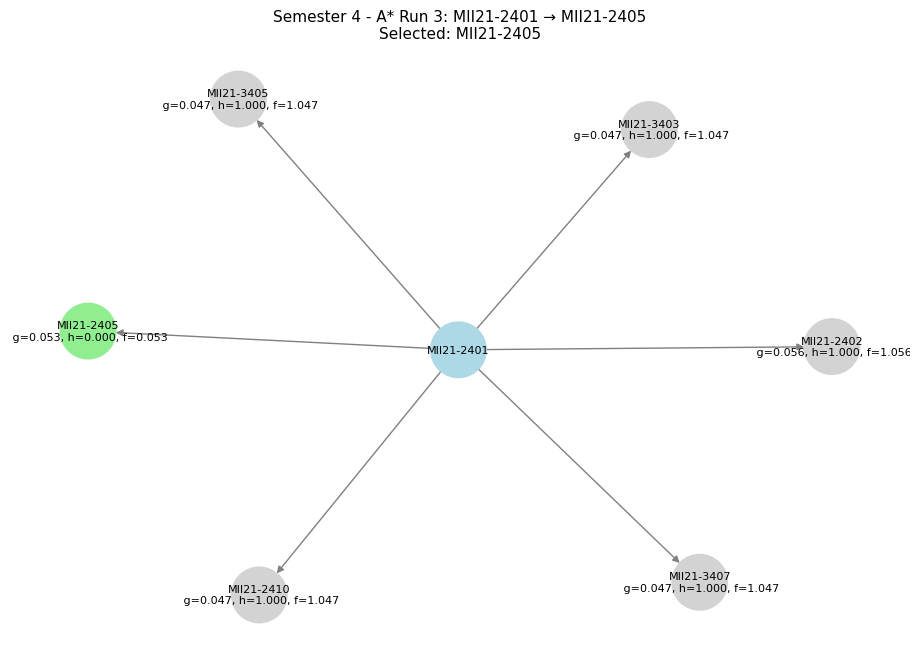

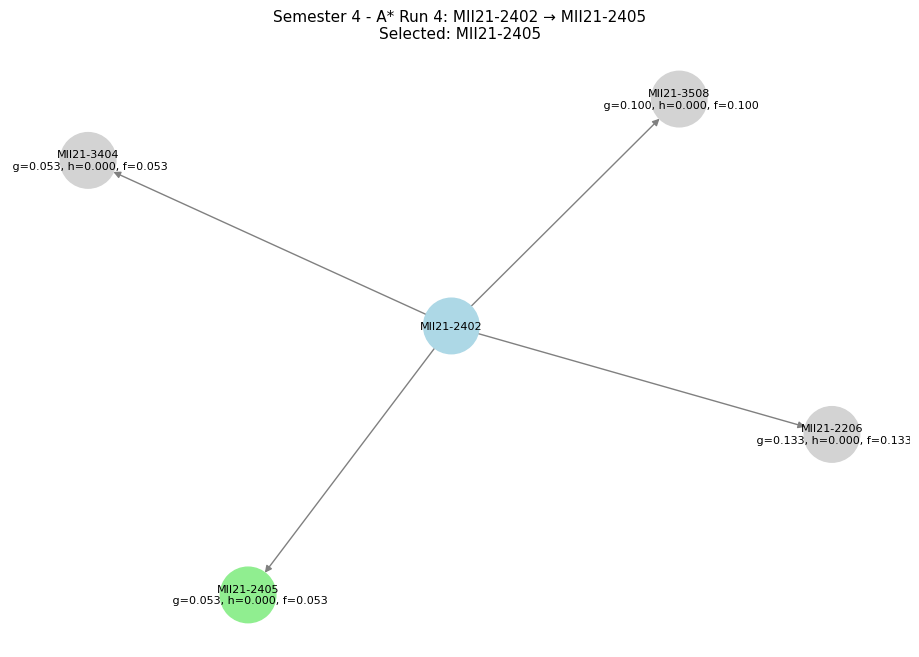

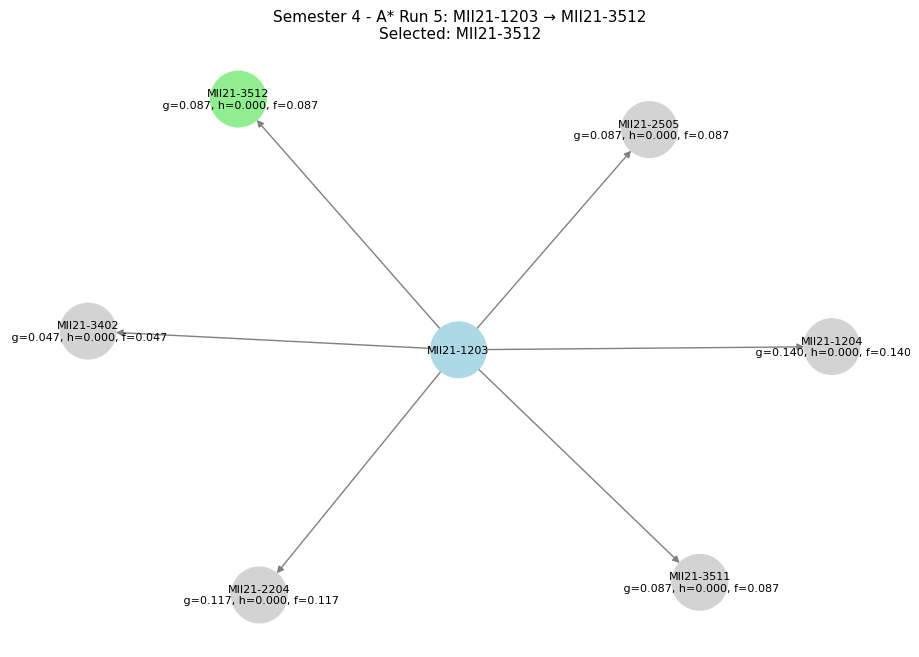

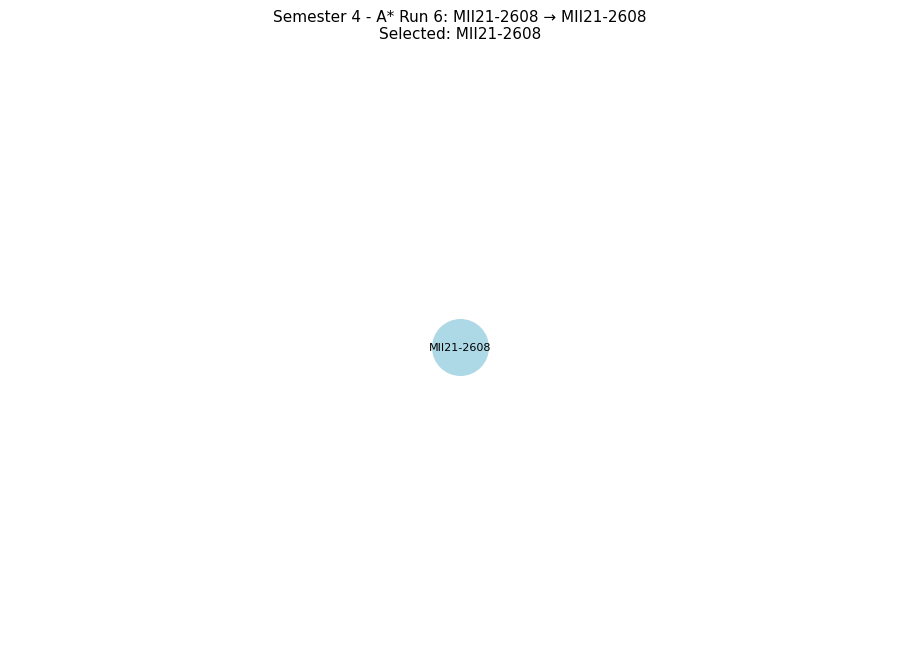

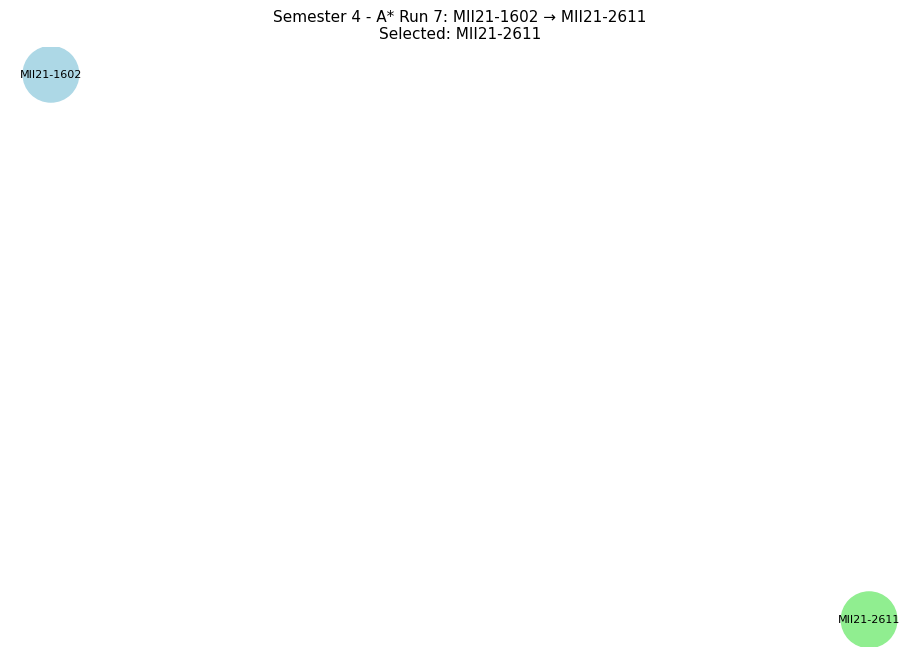

In [17]:
import re
import networkx as nx
import matplotlib.pyplot as plt

def parse_astar_log(log_text, semester_filter="Semester 4"):
    """
    Parse the A* debug output and extract:
      - start, goal pairs
      - nodes with g(n), h(n), f(n)
      - selected course for each run
    Only includes runs under the specified semester.
    """
    runs = []
    current_run = None
    inside_target_semester = False

    for line in log_text.splitlines():
        line = line.strip()
        if not line:
            continue

        # Detect semester header
        if line.startswith("===") and semester_filter in line:
            inside_target_semester = True
            continue
        elif line.startswith("===") and semester_filter not in line:
            inside_target_semester = False
            continue

        if not inside_target_semester:
            continue  # Skip other semesters

        # Start of a new A* run
        if "Running A*" in line:
            if current_run:
                runs.append(current_run)
            match = re.search(r"Running A\* from (\S+) → (\S+)", line)
            if match:
                current_run = {
                    "start": match.group(1),
                    "goal": match.group(2),
                    "nodes": {},   # node → (g, h, f)
                    "selected": None
                }
            continue

        # Extract node metrics: g(n), h(n), f(n)
        if current_run and re.match(r"^[A-Z0-9\-]+\s+[0-9\.\-]+\s+[0-9\.\-]+\s+[0-9\.\-]+", line):
            parts = line.split()
            node = parts[0]
            try:
                g, h, f = map(float, parts[1:4])
                current_run["nodes"][node] = (g, h, f)
            except Exception:
                pass
            continue

        # Capture selected node
        if "✅" in line and current_run:
            match = re.search(r"✅ (\S+)", line)
            if match:
                current_run["selected"] = match.group(1)

    if current_run:
        runs.append(current_run)

    return runs


def visualize_astar_runs(runs):
    """
    Visualize parsed A* runs with g(n), h(n), f(n) values.
    """
    for i, run in enumerate(runs, start=1):
        G = nx.DiGraph()
        start = run.get("start")
        goal = run.get("goal")
        nodes = run.get("nodes", {})
        selected = run.get("selected")

        if not start or not goal:
            continue

        # Build edges simply from start → each explored node
        for node in nodes.keys():
            if node != start:
                G.add_edge(start, node)

        # Add all nodes (in case some are isolated)
        for node in [start, goal, selected]:
            if node:
                G.add_node(node)

        plt.figure(figsize=(9, 6))
        pos = nx.spring_layout(G, seed=42)
        node_colors = []
        for node in G.nodes():
            if node == start:
                node_colors.append("lightblue")
            elif node == goal:
                node_colors.append("lightgreen")
            elif node == selected:
                node_colors.append("gold")
            else:
                node_colors.append("lightgray")

        # Node labels: include g, h, f if available
        node_labels = {}
        for node in G.nodes():
            if node in nodes:
                g, h, f = nodes[node]
                node_labels[node] = f"{node}\n g={g:.3f}, h={h:.3f}, f={f:.3f}"
            else:
                node_labels[node] = node

        nx.draw(
            G, pos, with_labels=False, node_color=node_colors,
            node_size=1600, font_size=9, arrows=True, edge_color="gray"
        )
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color="black")

        plt.title(f"Semester 4 - A* Run {i}: {start} → {goal}\nSelected: {selected or '-'}", fontsize=11)
        plt.show()


# === Example Usage ===
if __name__ == "__main__":
    with open("astar_log.txt", "r", encoding="utf-8") as f:
        log_text = f.read()

    runs = parse_astar_log(log_text, semester_filter="Semester 4")
    print(f"✅ Parsed {len(runs)} A* runs for Semester 4.")
    visualize_astar_runs(runs)


✅ Parsed 7 A* runs for Semester 4.


/tmp/ipykernel_6607/745141741.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


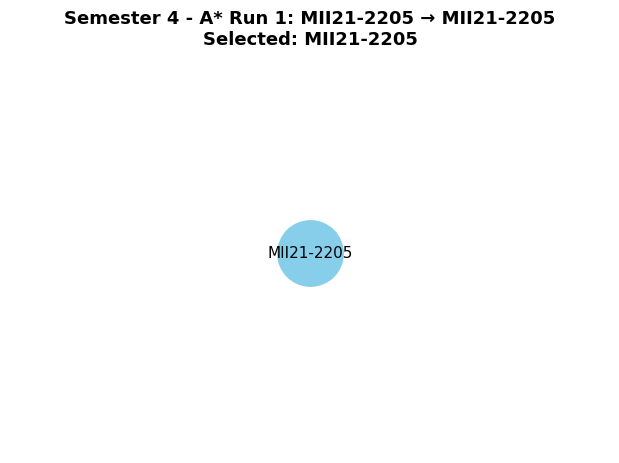

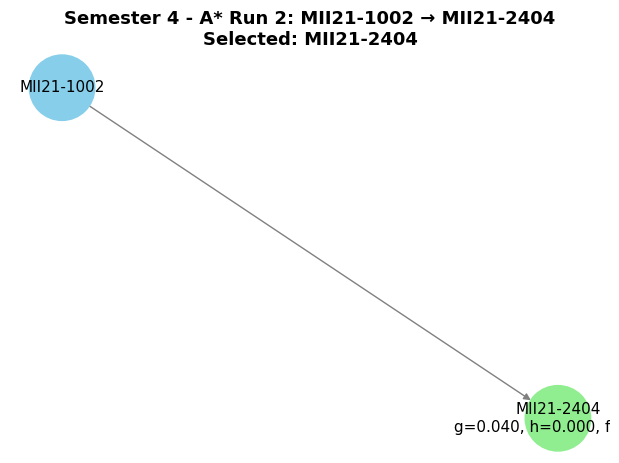

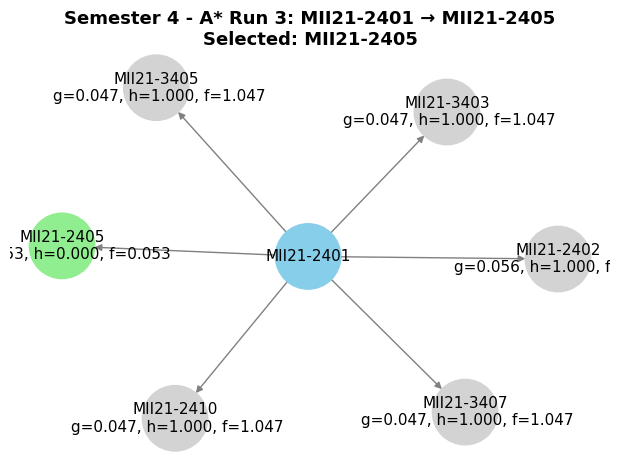

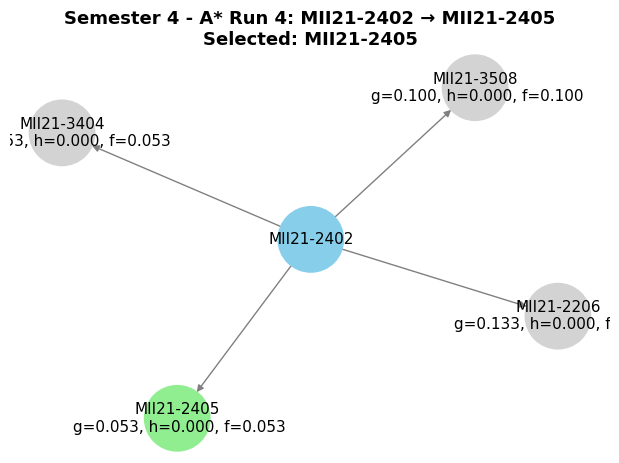

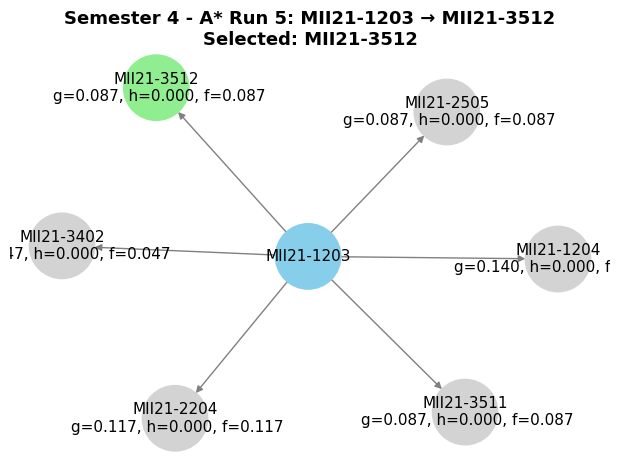

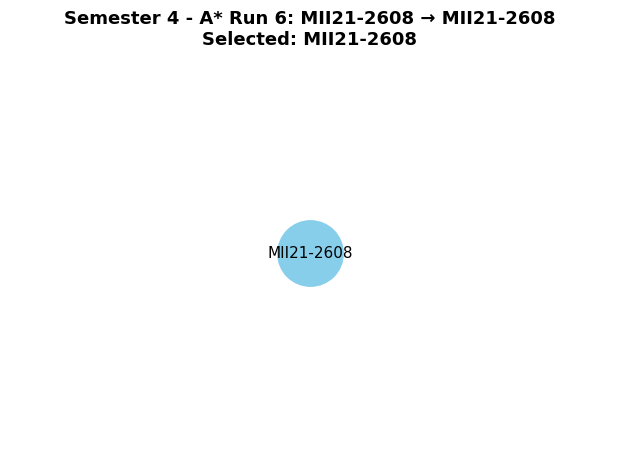

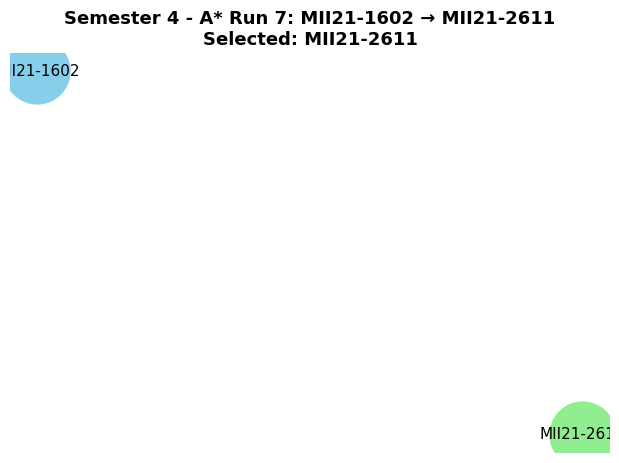

In [18]:
import re
import networkx as nx
import matplotlib.pyplot as plt

def parse_astar_log(log_text, semester_filter="Semester 4"):
    """
    Parse the A* debug output and extract:
      - start, goal pairs
      - nodes with g(n), h(n), f(n)
      - selected course for each run
    Only includes runs under the specified semester.
    """
    runs = []
    current_run = None
    inside_target_semester = False

    for line in log_text.splitlines():
        line = line.strip()
        if not line:
            continue

        # Detect semester header
        if line.startswith("===") and semester_filter in line:
            inside_target_semester = True
            continue
        elif line.startswith("===") and semester_filter not in line:
            inside_target_semester = False
            continue

        if not inside_target_semester:
            continue

        # Start of a new A* run
        if "Running A*" in line:
            if current_run:
                runs.append(current_run)
            match = re.search(r"Running A\* from (\S+) → (\S+)", line)
            if match:
                current_run = {
                    "start": match.group(1),
                    "goal": match.group(2),
                    "nodes": {},
                    "selected": None
                }
            continue

        # Extract node metrics (g, h, f)
        if current_run and re.match(r"^[A-Z0-9\-]+\s+[0-9\.\-]+\s+[0-9\.\-]+\s+[0-9\.\-]+", line):
            parts = line.split()
            node = parts[0]
            try:
                g, h, f = map(float, parts[1:4])
                current_run["nodes"][node] = (g, h, f)
            except Exception:
                pass
            continue

        # Capture selected node
        if "✅" in line and current_run:
            match = re.search(r"✅ (\S+)", line)
            if match:
                current_run["selected"] = match.group(1)

    if current_run:
        runs.append(current_run)

    return runs


def visualize_astar_runs(runs):
    """
    Visualize parsed A* runs with g(n), h(n), f(n) values.
    Smaller figure, larger readable text for presentation.
    """
    for i, run in enumerate(runs, start=1):
        G = nx.DiGraph()
        start = run.get("start")
        goal = run.get("goal")
        nodes = run.get("nodes", {})
        selected = run.get("selected")

        if not start or not goal:
            continue

        # Build simple edges start → node
        for node in nodes.keys():
            if node != start:
                G.add_edge(start, node)

        for node in [start, goal, selected]:
            if node:
                G.add_node(node)

        # === Visualization tweaks ===
        plt.figure(figsize=(6, 4))  # smaller figure
        pos = nx.spring_layout(G, seed=42, k=0.7)  # tighter spacing

        # Colors
        node_colors = []
        for node in G.nodes():
            if node == start:
                node_colors.append("skyblue")
            elif node == goal:
                node_colors.append("lightgreen")
            elif node == selected:
                node_colors.append("gold")
            else:
                node_colors.append("lightgray")

        # Labels (bigger font)
        node_labels = {}
        for node in G.nodes():
            if node in nodes:
                g, h, f = nodes[node]
                node_labels[node] = f"{node}\n g={g:.3f}, h={h:.3f}, f={f:.3f}"
            else:
                node_labels[node] = node

        nx.draw(
            G, pos,
            with_labels=False,
            node_color=node_colors,
            node_size=2200,     # slightly smaller nodes
            font_size=14,       # larger text for presentation
            arrows=True,
            edge_color="gray",
            linewidths=1.2
        )
        nx.draw_networkx_labels(
            G, pos,
            labels=node_labels,
            font_size=11,       # larger font for node text
            font_color="black",
            verticalalignment='center'
        )

        plt.title(f"Semester 4 - A* Run {i}: {start} → {goal}\nSelected: {selected or '-'}",
                  fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()


# === Example Usage ===
if __name__ == "__main__":
    with open("astar_log.txt", "r", encoding="utf-8") as f:
        log_text = f.read()

    runs = parse_astar_log(log_text, semester_filter="Semester 4")
    print(f"✅ Parsed {len(runs)} A* runs for Semester 4.")
    visualize_astar_runs(runs)
